# plot

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import greatpy as great 
import bindome as bd 

import matplotlib.pyplot as plt 
import seaborn as sns 

import pandas as pd 
import numpy as np 

import time

In [12]:
test = "../data/tests/test_data/input/01_random.bed"
regdom = "../data/human/hg38/regulatory_domain.bed"

## Count plot

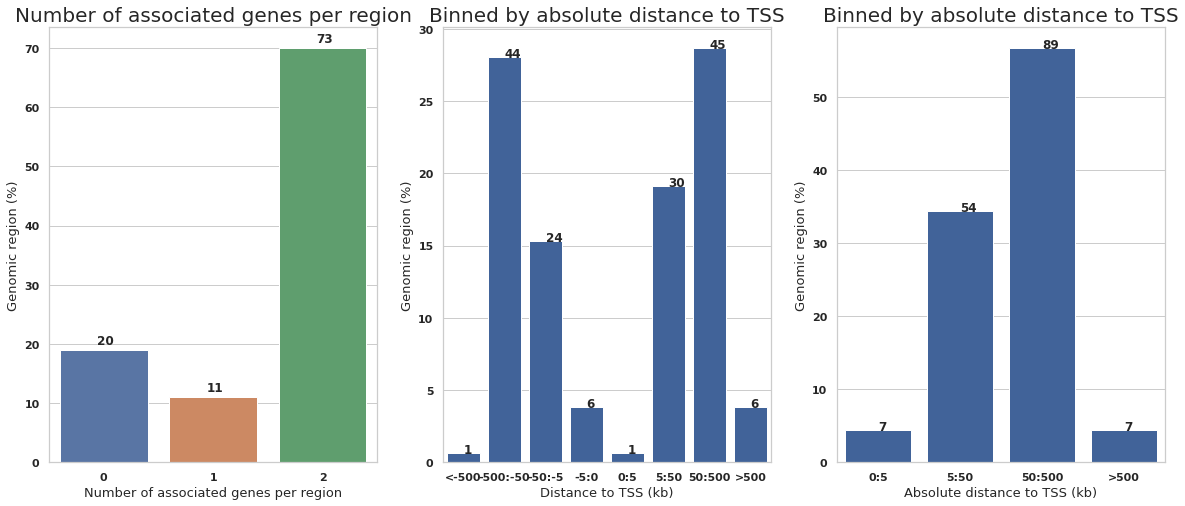

In [13]:
fig,ax = plt.subplots(1,3,figsize=(20,8))
great.pl.graph_nb_asso_per_peaks(test,regdom,ax[0])
great.pl.graph_dist_tss(test,regdom,ax[1])
great.pl.graph_absolute_dist_tss(test,regdom,ax[2])
plt.show()

## Dotplot

In [14]:
enrichment = great.tl.GREAT.enrichment(
    test,
    regdom,
    "../data/human/hg38/chr_size.bed", 
    "../data/human/ontologies.csv"
)

In [15]:
enrichment

,go_term,binom_p_value,binom_fold_enrichment,hypergeom_p_value,hypergeometric_fold_enrichment,intersection_size,recall
GO:0045887,positive regulation of synaptic growth at neur...,5.20389e-13,2.18004e+05,3.08889e-03,3.23741e+02,4,4.00000e+00
GO:0044721,"protein import into peroxisome matrix, substra...",4.84198e-10,3.94065e+04,3.08889e-03,3.23741e+02,4,4.00000e+00
GO:0036250,peroxisome transport along microtubule,4.84198e-10,3.94065e+04,3.08889e-03,3.23741e+02,4,4.00000e+00
GO:0016561,"protein import into peroxisome matrix, translo...",6.31855e-10,3.68645e+04,6.16839e-03,1.61871e+02,4,2.00000e+00
GO:0030576,Cajal body organization,1.49190e-09,2.97236e+04,1.83932e-02,5.39569e+01,4,6.66667e-01
...,...,...,...,...,...,...,...
GO:0006355,"regulation of transcription, DNA-templated",9.93956e-01,2.08617e+01,8.40449e-01,5.54352e-01,1,1.71233e-03
GO:0006915,apoptotic process,9.95014e-01,2.01230e+01,5.39651e-01,1.11443e+00,1,1.72117e-03
GO:0042803,protein homodimerization activity,9.98551e-01,2.44788e+01,9.54394e-01,3.33067e-01,2,2.05761e-03
GO:0005737,cytoplasm,9.98903e-01,6.55886e+01,9.92060e-01,5.70469e-01,24,4.22907e-03


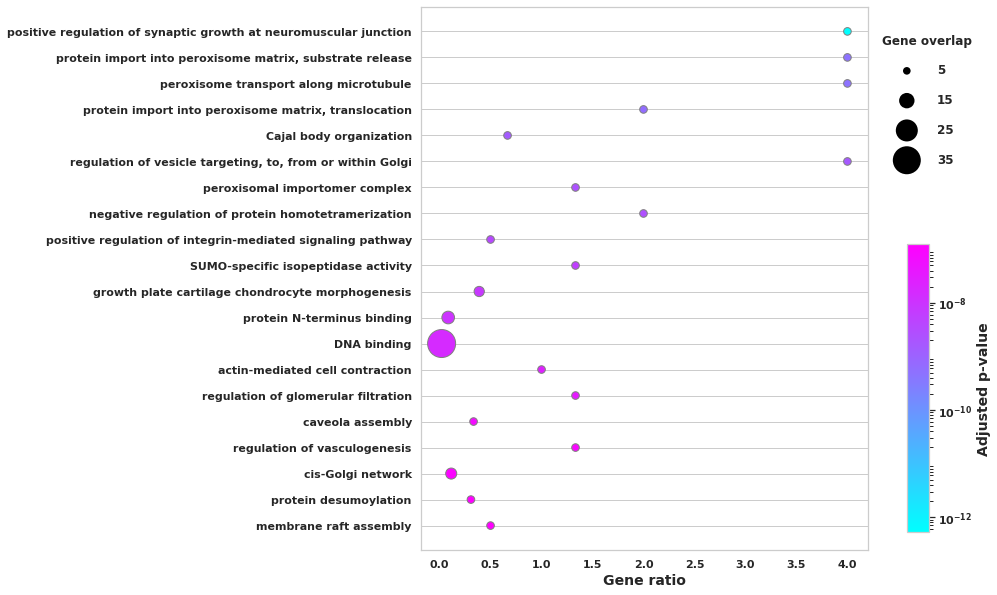

In [16]:
plot = enrichment.rename(columns={"binom_p_value" : "p_value", "go_term":"name"})
plt.figure(figsize=(10,10))
great.pl.plot_enrich(plot)

In [159]:
import matplotlib

test = [
    # "SRF:Ishikawa,A-673-clone-Asp114,K-562,MCF-7,Hep-G2",
    "MAX:K-562,WA01,HeLa-S3", "BACH1:A-549,GM12878",
    # "CDK9:A-375,MM1-S,MV4-11,P493-6,BT-474,HEK293T",
    "GATA1:erythroblast,HUDEP-2,K-562", "IKZF1:K-562,GM12878,HSPC", 
    # "SP1:liver,A-375,Hep-G2,HEK293,GM12878,A-549,K-562,HEK293T,WA01",
    # "TCF7:Hep-G2,GM12878,K-562", "ZBTB40:MCF-7,Hep-G2,GM12878",
    "AFF1:MV4-11,K-562"
    ]

def dotplot(test_data,annpath, n_row:int = 5,fig : matplotlib.figure.Figure or None = None,terms : bool = False): 
    """
    Dotplot of enrichment GO terms for a given list of example genomic regions.

    Parameters
    ----------
    test_data : list
        List of biosample in SRF to be tested.
    annpath : str
        Path to the annotation repo 
    n_row : int
        Number of rows pick in each dataframe.
    fig : matplotlib.figure.Figure or None 
        Figure to plot the dotplot. 
    
    Returns
    -------
    None.


    """
    min_p,min_od,max_p,max_od = 100,100,0,0
    bd.bindome.constants.ANNOTATIONS_DIRECTORY = annpath
    gene_tot={}
    df = pd.DataFrame()

    for i,name in enumerate(test_data) :
        gene_tot[i] = name.split(":")[0]
        srf = bd.bindome.datasets.REMAP2020.get_remap_peaks(name.split(":")[0])
        tmp = srf[srf[3]==name].iloc[:,0:3]
        tmp = tmp.rename(columns={"chr":'Chr','start':"Chr_start",'end':"Chr_end"})

        res = great.tl.GREAT.enrichment(
            test_file = tmp,
            regdom_file="../data/human/hg38/regulatory_domain.bed",
            chr_size_file="../data/human/hg38/chr_size.bed",
            annotation_file="../data/human/ontologies.csv",
            binom=True,
            hypergeom=True,
            ).sort_values(by="hypergeom_p_value").iloc[:n_row]

        res = res.reset_index().rename(columns={"index":"id"})
        res["index"] = [i]*n_row
        frames = [df, res]
        df = pd.concat(frames)

        # time.sleep(30)

        print(f"done ... {i}")

    df["hypergeom_p_value"] = -np.log(df["hypergeom_p_value"])
    df["hypergeometric_fold_enrichment"] = np.log2(df["hypergeometric_fold_enrichment"])
        

    p_val = df.pivot("id","index","hypergeom_p_value").fillna(1).rename(columns=gene_tot).reindex(df["id"])
    odd_ratio = df.pivot("id","index","hypergeometric_fold_enrichment").fillna(0).rename(columns=gene_tot).reindex(df["id"])

    if terms : 
        try : 
            go_term = []
            go = list(p_val.index)
            term = list(df.go_term)
            for i in range(len(go)) :
                go_term.append(f"{go[i]} {term[i][:50]}")
            p_val["go_id"] = go_term
            odd_ratio["go_id"] = go_term
            p_val.set_index("go_id",inplace=True)
            odd_ratio.set_index("go_id",inplace=True)
        except :
            print("an error occured")
            pass

    for i in p_val.columns : 
        if min_p > p_val[i].min() : 
            min_p = p_val[i].min()
        if max_p < p_val[i].max() : 
            max_p = p_val[i].max()

    for i in odd_ratio.columns : 
        if min_od > odd_ratio[i].min() : 
            min_od = odd_ratio[i].min()
        if max_od < odd_ratio[i].max() : 
            max_od = odd_ratio[i].max()
    
    plt.rcParams.update({"font.size": 14, "font.weight": "normal"})
    
    great.pl.make_bubble_heatmap(
        p_val,odd_ratio,quantAmplifier = 7,
        circle_legend_ticks=[i for i in range(round(min_od),round(max_od)+1,2)],
        palette_id="Reds",ylab='',xlab='', tickscolorbar=[i for i in range(round(min_p),round(max_p)+1)],
        vmin=min_p,vmax=max_p, cbar_label='-log(p_hypergeometric)', marker='o', legend_title='odds.ratio',
        heatmap_title = "Dotplot of enrichment GO terms",sig_line_width=0.1, fig=fig
        )
    
    return p_val,odd_ratio,df

done ... 0
done ... 1
done ... 2
done ... 3
done ... 4


/home/tom/.local/lib/python3.8/site-packages/greatpy/pl/basic.py:447: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  order_frame = order_frame.reindex(index=order_frame.index[::-1])


ValueError: cannot reindex on an axis with duplicate labels

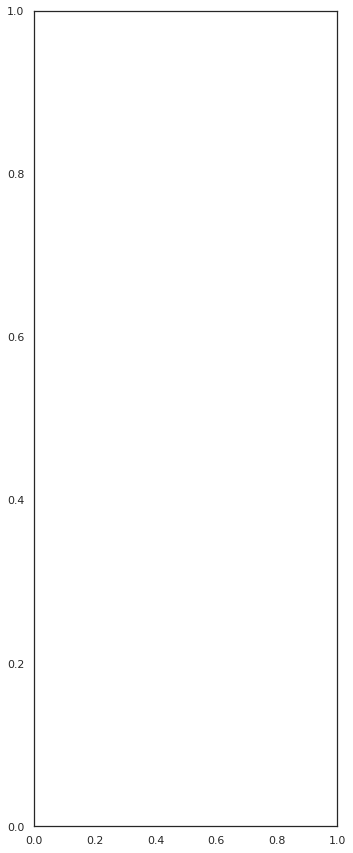

In [160]:
fig = plt.figure(figsize=(25, 15))
p_val,odd_ratio,df = dotplot(test,annpath="../../annotation/",fig=fig,terms=False)